# Regression algorithms

Before looking at this notebook, make sure you have a good grasp of [linear regression](Linear_regression.ipynb) and how to use it.

This notebook explores some other approaches to regression. We'll continue to estimate a single dependent variable from a single independent variable (`X`).

All of these have been gathered in one script in [this Gist](https://gist.github.com/kwinkunks/48f86f4c368f5003d13dee734a16800c).


## Datasets

Let's make some datasets. The `noise` parameter is the standard deviation of the noise.

In [21]:
def make_linear(N=50, noise=3, random_state=None, w=10, b=3):
    """Make x and y for a 1D linear regression problem."""
    def f(x, w, b):
        return w*x + b
    rng = np.random.default_rng(random_state)
    x = np.linspace(-2.5, 2.5, num=N) + rng.normal(0, noise/10, N)
    y = f(x, w, b) + rng.normal(0, noise, N)
    return x.reshape(-1, 1), y

x0, y0 = make_linear()

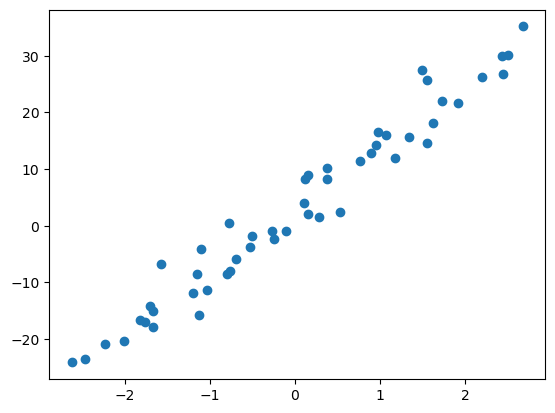

In [22]:
import matplotlib.pyplot as plt

plt.scatter(x0, y0)

In [27]:
def make_noisy(N=50, noise=3, random_state=None):
    xa, ya = make_linear(N=N, noise=noise, random_state=random_state)

    rng = np.random.default_rng(random_state)
    
    if noise:
        xn = np.linspace(-2.5, 2.5, num=N//2)
        yn = 70 * (0.5 - rng.random(size=N//2))
        xy = [[x, y] for x, y in zip(xn, yn) if y < 10*x -3]
        xb, yb = np.array(xy).T
    else:
        xb, yb = np.array([]), np.array([])

    return np.vstack([xa, xb.reshape(-1, 1)]), np.hstack([ya, yb])

x00, y00 = make_noisy()

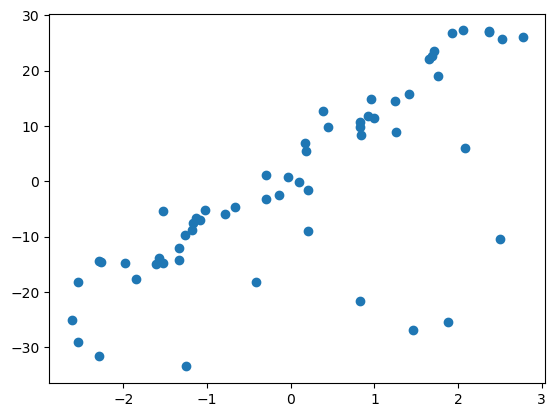

In [28]:
plt.scatter(x00, y00)

Now let's generate a polynomial dataset:

In [29]:
def make_poly(N=50, noise=3, random_state=None):
    def f(x):
        return 3*x**2 + 9*x - 10
    rng = np.random.default_rng(random_state)
    x = np.linspace(-2.25, 2.25, num=N) + rng.normal(0, noise/10, N)
    y = f(x) + rng.normal(0, noise, N)
    return x.reshape(-1, 1), y

x1, y1 = make_poly()

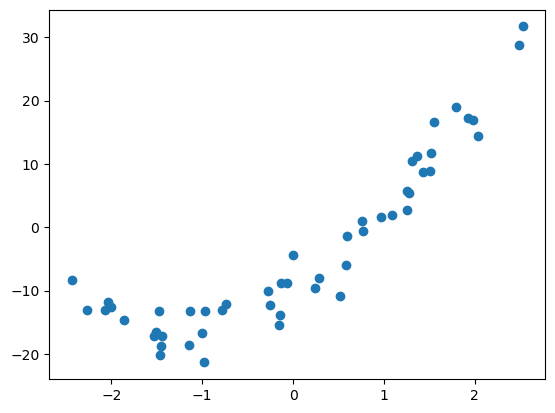

In [30]:
plt.scatter(x1, y1)

And a periodic one:

In [25]:
def make_periodic(N=50, noise=3, random_state=None):
    def f(x):
        return 10*np.sin(5*x) + 3*np.cos(3*x) + 5*np.sin(7*x)
    rng = np.random.default_rng(42)
    x = np.linspace(-2.25, 2.25, num=N) + rng.normal(0, noise/10, N)
    y = f(x) + rng.normal(0, noise, N)
    return x.reshape(-1, 1), y

x2, y2 = make_periodic()

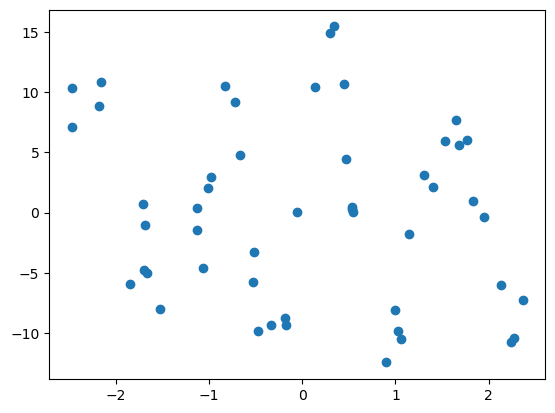

In [26]:
plt.scatter(x2, y2)

## Predictions

We'll choose a lot of different algorithms. For each one we'll try one application with no regularization, and one with fairly substantial (and not necessarily optimal) regularization. In general, regularization will reduce the complexity of the model, with the goal of reducing the chances of overfitting.


### Linear regression

First, linear regression. We will use 'ridge' regression, which applies L2 (aka Tikhonov) regularization. If we set the `alpha` parameter to 0, we'll get ordinary, unregularized, linear regression.

**Note:** We know that overfitting is not an issue for univariate linear regression, but you can use the same code for multivariate problems and we'll see some algorithms for which it is a problem, even for univariate problems. But for this particular example, you can ignore the regularized model.

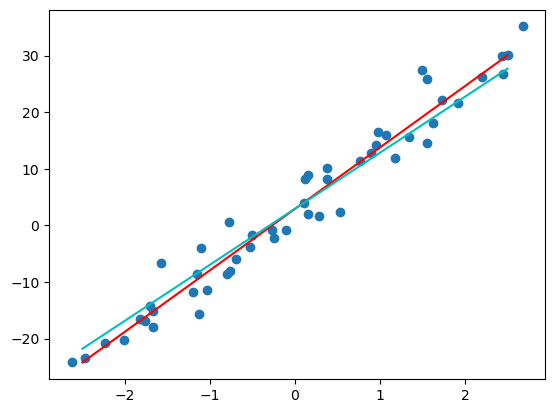

In [31]:
from sklearn.linear_model import Ridge

m = Ridge(alpha=0).fit(x0, y0)   # Unregularized.
r = Ridge(alpha=10).fit(x0, y0)  # Regularized.

x0m = np.linspace(-2.5, 2.5).reshape(-1, 1)
ŷ0m = m.predict(x0m)
ŷ0r = r.predict(x0m)

plt.scatter(x0, y0)
plt.plot(x0m, ŷ0m, 'r')
plt.plot(x0m, ŷ0r, 'c')

Let's turn the plotting into a function:

In [32]:
def compare(model1, model2, dataset='linear'):
    """We'll just use side-effects and globals. I'm not proud."""
    data = {
        'linear': (x0, y0),
        'noisy': (x00, y00),
        'poly': (x1, y1),
        'periodic': (x2, y2),
    }
    
    x, y = data[dataset]
    
    x1m = np.linspace(-2.5, 2.5).reshape(-1, 1)
    ŷ1m = model1.predict(x1m)
    ŷ1r = model2.predict(x1m)

    plt.scatter(x, y)
    plt.plot(x1m, ŷ1m, 'r')
    plt.plot(x1m, ŷ1r, 'c')
    return

So we can easily look at the performance of these models on the noisy linear dataset:

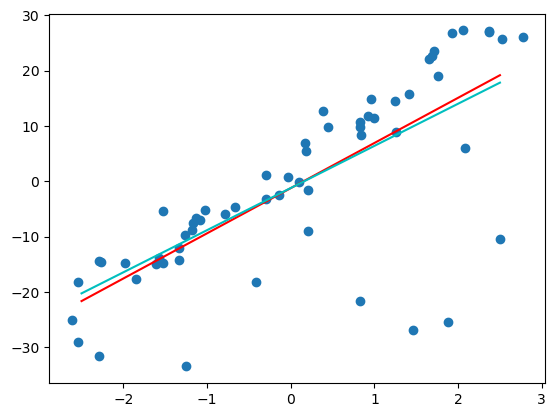

In [33]:
m = Ridge(alpha=0).fit(x00, y00)
r = Ridge(alpha=10).fit(x00, y00)

compare(m, r, dataset='noisy')

Now here's the polynomial dataset, which cannot be predicted by this model without a lot of error:

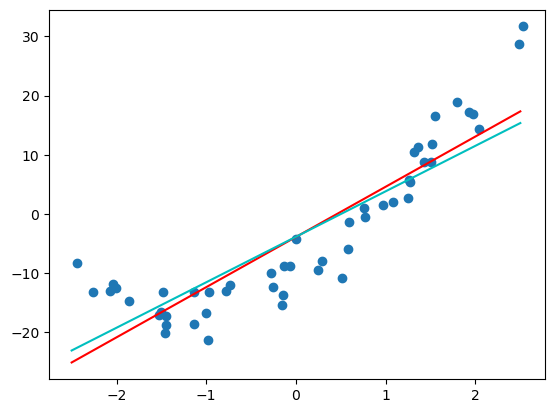

In [34]:
m = Ridge(alpha=0).fit(x1, y1)
r = Ridge(alpha=10).fit(x1, y1)

compare(m, r, dataset='poly')

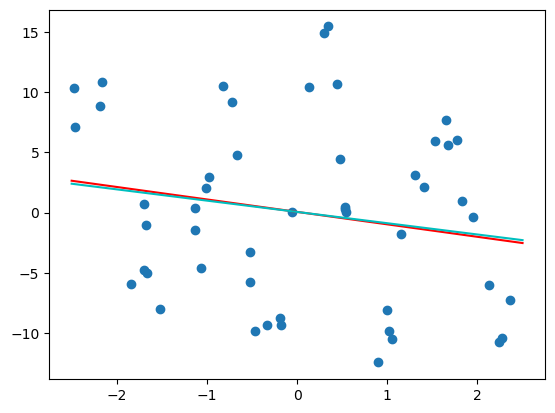

In [35]:
m = Ridge(alpha=0).fit(x2, y2)
r = Ridge(alpha=10).fit(x2, y2)

compare(m, r, dataset='periodic')

## Robust estimator

Robust estimators try to account for noise. In `sklearn` they include `TheilSenRegressor`and `HuberRegressor`. We'll compare teh Huber with ordinary linear regression on the 'noisy linear' dataset:

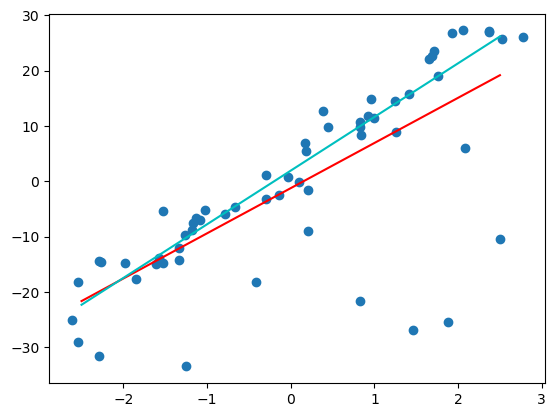

In [36]:
from sklearn.linear_model import HuberRegressor

lr = LinearRegression().fit(x00, y00)  # Red
re = HuberRegressor().fit(x00, y00)    # Blue

compare(lr, re, dataset='noisy')

The robust estimator does a better job of ignoring the noise and fitting the trend expressed in the majority of the data.

## More algorithms

For now, please check out [this Gist](https://gist.github.com/kwinkunks/48f86f4c368f5003d13dee734a16800c) for the rest of the comparisons.

    'Nearest Neighbours': dict(model=KNeighborsRegressor(), pen='n_neighbors', mi=3, ma=9),
    'Linear SVM': dict(model=SVR(kernel='linear'), pen='C', mi=1e6, ma=1),
    'RBF SVM': dict(model=SVR(kernel='rbf'), pen='C', mi=1e6, ma=1),
    'Gaussian Process': dict(model=GaussianProcessRegressor(random_state=random_state), pen='alpha', mi=1e-12, ma=1),
    'Decision Tree': dict(model=DecisionTreeRegressor(random_state=random_state), pen='max_depth', mi=20, ma=3),
    'Random Forest': dict(model=RandomForestRegressor(random_state=random_state), pen='max_depth', mi=20, ma=4),
    'Neural Net': dict(model=MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, tol=0.01, random_state=random_state), pen='alpha', mi=0, ma=10),    
